In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 22.5 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import optuna
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [3]:
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
import zipfile
import os

zip_path = "/content/Places2_simp_resit.zip"
extract_path = "/content/Places2_simp_ayush"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
transform_train =  transforms.Compose([
     transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=20),
    TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset_path = "/content/Places2_simp_ayush/Places2_simp"

dataset =  ImageFolder(root= dataset_path, transform= transform_train)
print(len(dataset))
print(len(dataset.classes))

40000
40


In [ ]:
from torch.utils.data import random_split

training_size = int(0.8 * len(dataset))
validation_size = len(dataset) - training_size

train_dataset, val_dataset = random_split(dataset, [training_size, validation_size],  generator=torch.Generator().manual_seed(40))

In [ ]:
val_dataset.dataset.transform = transforms_val
train_dataLoader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataLoader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Feature batch shape: torch.Size([100, 3, 224, 224])
Labels batch shape: torch.Size([100])


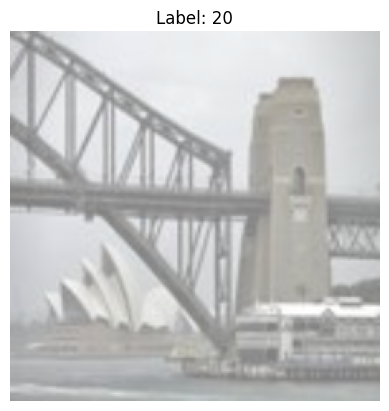

In [ ]:
train_features, train_labels = next(iter(train_dataLoader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1, 2, 0)
img = img * 0.5 + 0.5
label = train_labels[0]
plt.imshow(img.numpy())
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

In [ ]:

from transformers import AutoFeatureExtractor, AutoModelForImageClassification

extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
base_model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")

num_classes = len(dataset.classes)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
base_model.classifier = nn.Sequential(
    nn.Linear(base_model.classifier.in_features, num_classes)
)

model = base_model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
epochs = 10

In [ ]:
for epoch in range(epochs):
    print(f"Starting epoch {epoch+1}/{epochs}")
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for features, labels in train_dataLoader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(features)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.logits.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total if total > 0 else 0
    print(f"[Epoch {epoch+1}] Train Loss: {running_loss/len(train_dataLoader):.4f}, Accuracy: {train_acc*100:.2f}%")

Starting epoch 1/10
[Epoch 1] Train Loss: 1.1764, Accuracy: 67.50%
Starting epoch 2/10
[Epoch 2] Train Loss: 0.5053, Accuracy: 84.62%
Starting epoch 3/10
[Epoch 3] Train Loss: 0.2226, Accuracy: 93.43%
Starting epoch 4/10
[Epoch 4] Train Loss: 0.0906, Accuracy: 97.67%
Starting epoch 5/10
[Epoch 5] Train Loss: 0.0506, Accuracy: 98.63%
Starting epoch 6/10
[Epoch 6] Train Loss: 0.0575, Accuracy: 98.32%
Starting epoch 7/10
[Epoch 7] Train Loss: 0.0776, Accuracy: 97.66%
Starting epoch 8/10
[Epoch 8] Train Loss: 0.0437, Accuracy: 98.75%
Starting epoch 9/10
[Epoch 9] Train Loss: 0.0468, Accuracy: 98.57%
Starting epoch 10/10
[Epoch 10] Train Loss: 0.0570, Accuracy: 98.21%


Top-1 Accuracy: 71.76%
Top-5 Accuracy: 93.89%


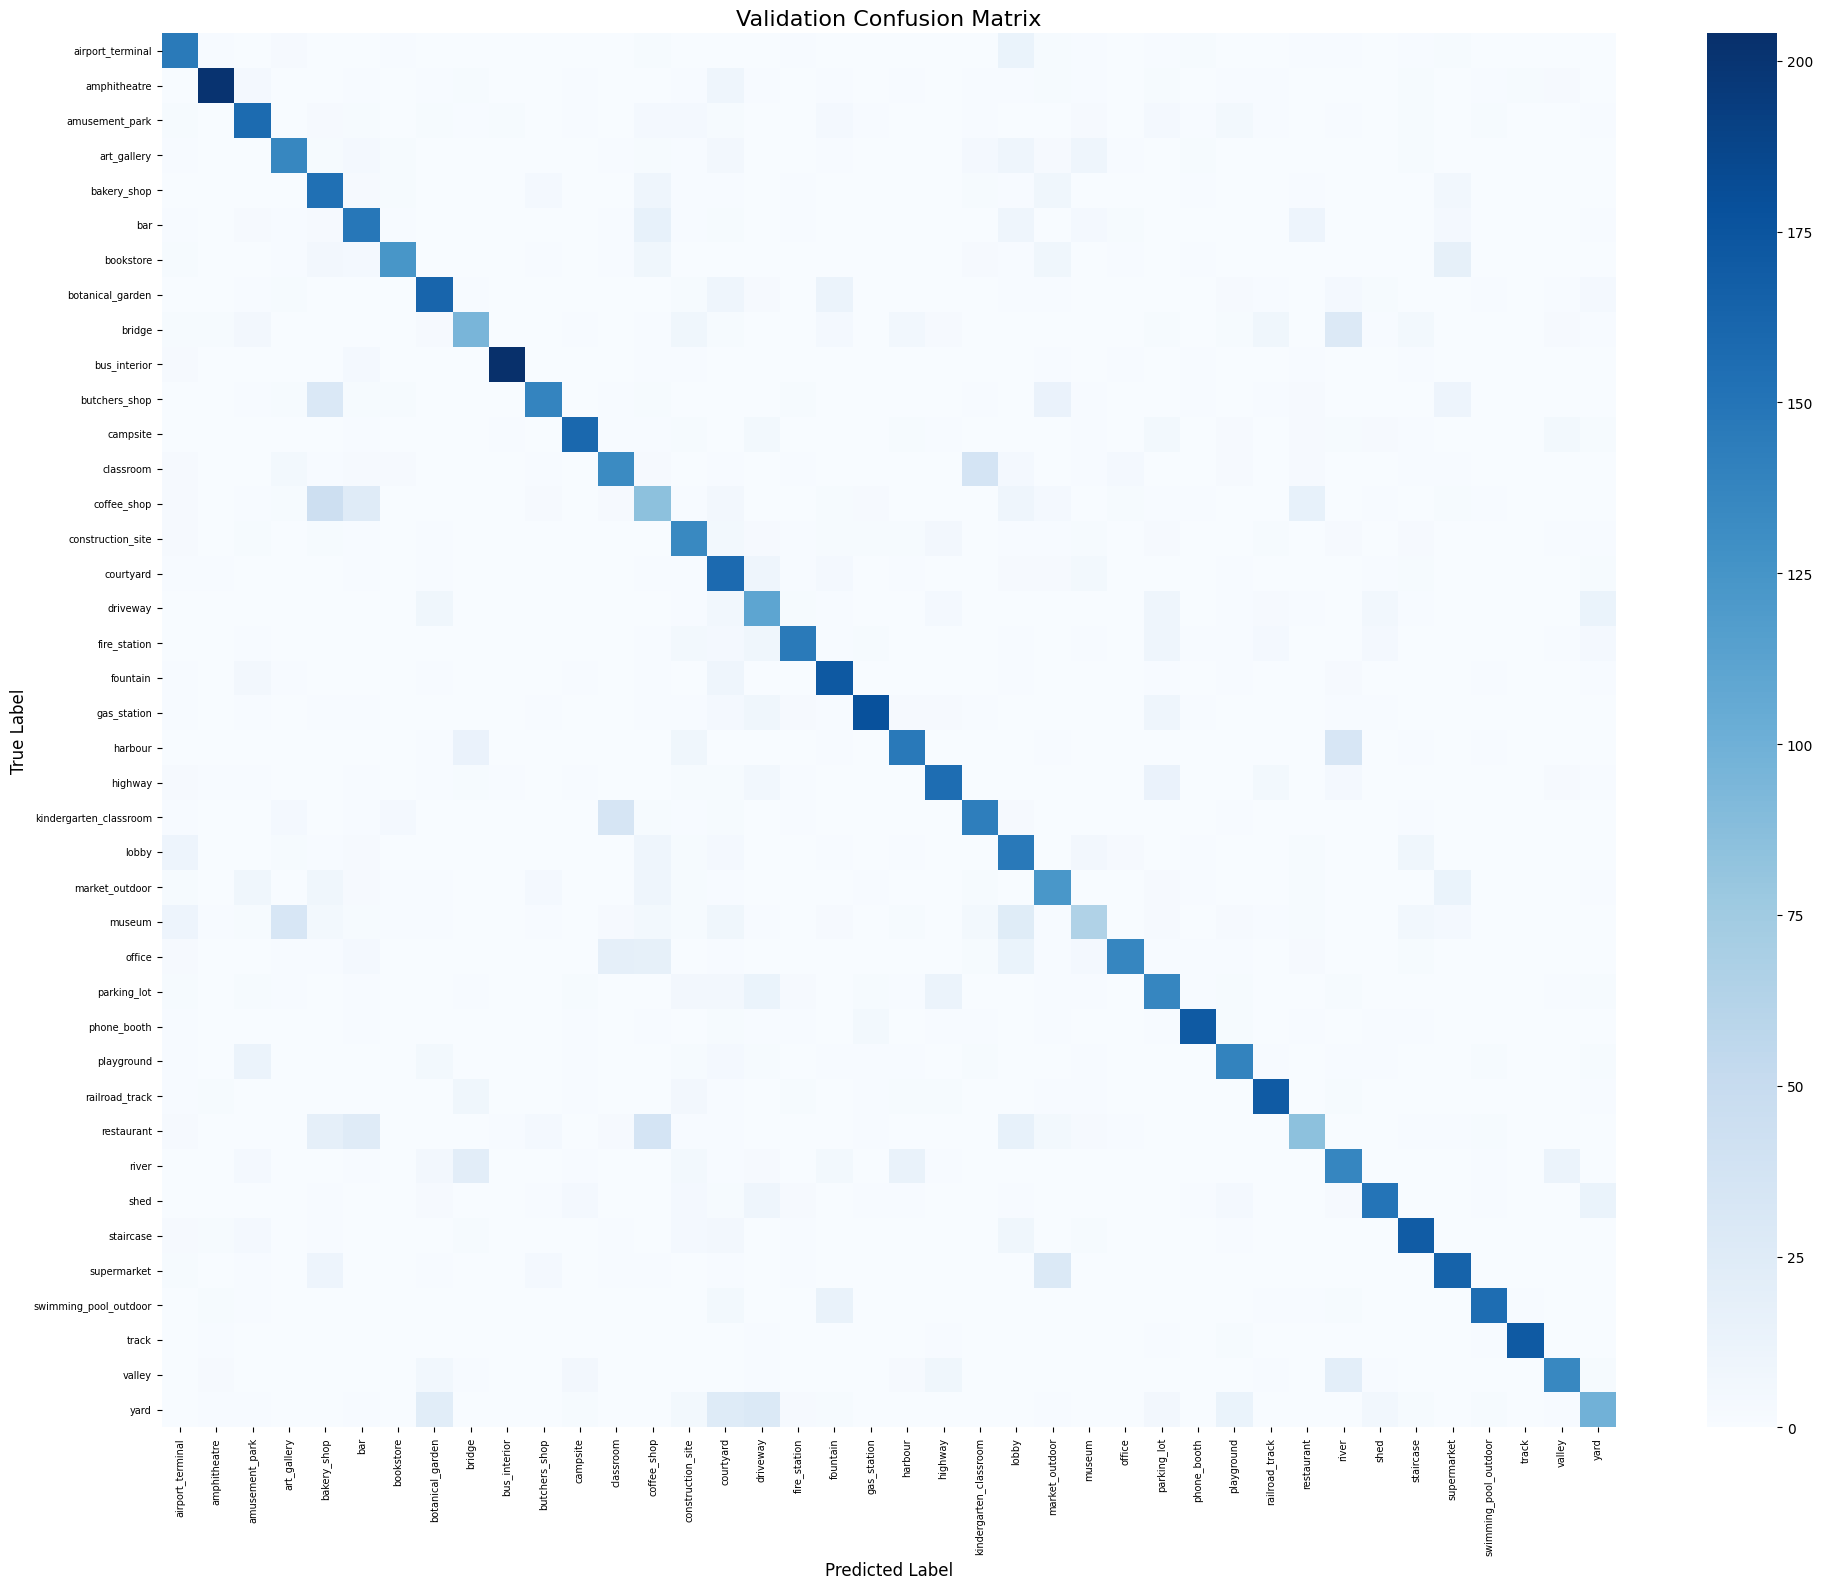

In [ ]:
model.eval()
with torch.no_grad():
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []

    for features, labels in val_dataLoader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        total += labels.size(0)

        # Top-1
        predicted1 = outputs.logits.topk(1, dim=1).indices.squeeze()
        top1_correct += (predicted1 == labels).sum().item()

        # Top-5
        top5_pred = outputs.logits.topk(5, dim=1).indices
        for i in range(labels.size(0)):
            if labels[i] in top5_pred[i]:
                top5_correct += 1

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted1.cpu().numpy())

top1_acc = 100 * top1_correct / total
top5_acc = 100 * top5_correct / total

print(f"Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=val_dataLoader.dataset.dataset.classes,
            yticklabels=val_dataLoader.dataset.dataset.classes)

plt.xticks(rotation=90, fontsize=7)
plt.yticks(rotation=0, fontsize=7)
plt.title("Validation Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()